In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import gc

# --- STEP 1: Load optimized feature names ---
features_raw = pd.read_csv('NUSW-NB15_features.csv', header=None, encoding='latin1')
base_features = features_raw[1].tolist()[:47]  # drop extras
feature_names = base_features + ['label', 'attack_cat']

# --- STEP 2: Generator to load files in chunks and append ---
def load_and_combine(files):
    for file in files:
        df = pd.read_csv(file, header=None, low_memory=False)
        if df.shape[1] > len(feature_names):  # avoid mismatch
            df = df.iloc[:, :len(feature_names)]
        df.columns = feature_names
        yield df

# --- STEP 3: Read and concatenate efficiently ---
files = ['UNSW-NB15_1.csv', 'UNSW-NB15_2.csv', 'UNSW-NB15_3.csv', 'UNSW-NB15_4.csv']
data_plain = pd.concat(load_and_combine(files), ignore_index=True)
del features_raw
gc.collect()

# --- STEP 4: Memory-efficient preprocessing ---
# Downcast numerics
for col in data_plain.select_dtypes(include='float64').columns:
    data_plain[col] = pd.to_numeric(data_plain[col], downcast='float')
for col in data_plain.select_dtypes(include='int64').columns:
    data_plain[col] = pd.to_numeric(data_plain[col], downcast='integer')

# Encode labels
label_encoder = LabelEncoder()
if data_plain['label'].dtype == object:
    data_plain['label'] = label_encoder.fit_transform(data_plain['label'])

# Drop non-numeric columns (like IPs or service names)
X_plain = data_plain.select_dtypes(include=[np.number]).drop(columns=['label'], errors='ignore')
y_plain = data_plain['label']
del data_plain
gc.collect()

# --- STEP 5: Scale and train-test split ---
scaler = StandardScaler()
X_plain = scaler.fit_transform(X_plain)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_plain, y_plain, test_size=0.3, random_state=42, stratify=y_plain)

del X_plain, y_plain
gc.collect()

# --- STEP 6: Train the model ---
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(Xp_train, yp_train)
acc = rf.score(Xp_test, yp_test)
print(f"✅ Random Forest accuracy (plain-text): {acc:.4f}")

# --- STEP 7: Save model and scaler ---
joblib.dump(rf, 'model_plain_rf.pkl')
joblib.dump(scaler, 'scaler_plain.pkl')


✅ Random Forest accuracy (plain-text): 0.9869


['scaler_plain.pkl']


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7270    0.8455    0.7818      1515
           1     0.9449    0.8849    0.9139      5759
           2     0.9280    0.7484    0.8286      3668
           3     0.6390    0.6192    0.6289       386
           4     0.8186    0.2080    0.3317       803
           5     0.8871    0.1020    0.1830       539
           6     0.0909    0.0125    0.0220       160
           7     0.3738    0.2619    0.3080      4906
           8     0.6388    0.8472    0.7284     13358
           9     0.9976    0.9863    0.9919     64644
          10     0.9302    0.8580    0.8926       528
          11     0.6364    0.4179    0.5045        67
          12     0.7500    0.1731    0.2812        52
          13     1.0000    1.0000    1.0000    665630

    accuracy                         0.9869    762015
   macro avg     0.7402    0.5689    0.5998    762015
weighted avg     0.9874    0.9869    0.9863    762015


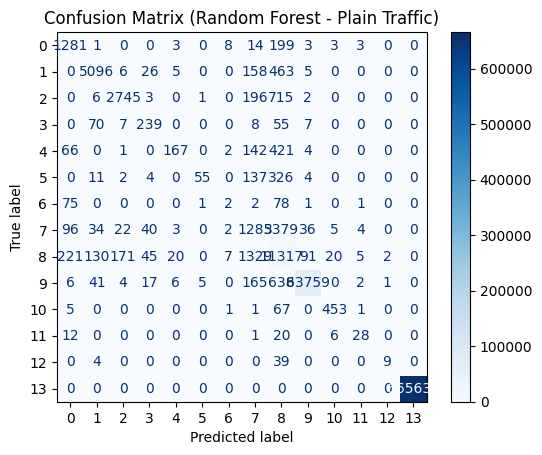

NameError: name 'data_plain' is not defined

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
yp_pred = rf.predict(Xp_test)

# --- 1. Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(yp_test, yp_pred, digits=4))

# --- 2. Confusion Matrix ---
print("\n🔢 Confusion Matrix:")
cm = confusion_matrix(yp_test, yp_pred)
print(cm)

# Optional: Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Random Forest - Plain Traffic)")
plt.grid(False)
plt.show()

# --- 3. ROC-AUC Score (Binary only) ---
if len(np.unique(yp_test)) == 2:
    probs = rf.predict_proba(Xp_test)[:, 1]
    roc_auc = roc_auc_score(yp_test, probs)
    print(f"\n🧠 ROC-AUC Score: {roc_auc:.4f}")

# Only needed if you use 'attack_cat' for multi-class classification
label_encoder = LabelEncoder()
y_attack = label_encoder.fit_transform(data_plain['attack_cat'])

# Show mapping
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("\n🗂️ Attack Category Label Mapping:")
for label, name in label_mapping.items():
    print(f"{label} => {name}")



In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import gc
import tensorflow as tf
import keras

# --- Model 2: Encrypted traffic (Neural Network) ---
# Load encrypted traffic features (assumed CSV with label column)
data_enc = pd.read_csv('encrypted_traffic_features.csv')
X_enc = data_enc.drop(columns=['label'], errors='ignore')
y_enc = data_enc['label']
# Encode labels if needed
if y_enc.dtype == object:
    y_enc = LabelEncoder().fit_transform(y_enc)
# Scale features
enc_scaler = StandardScaler()
X_enc = enc_scaler.fit_transform(X_enc)
# Train/test split
Xe_train, Xe_test, ye_train, ye_test = train_test_split(
    X_enc, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

# Define a simple neural network
model_enc = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(Xe_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_enc)), activation='softmax')  # multi-class output
])
model_enc.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
# Train the model (use GPU if available)
model_enc.fit(Xe_train, ye_train, epochs=10, batch_size=256, validation_split=0.1)
# Evaluate
loss, acc_enc = model_enc.evaluate(Xe_test, ye_test, verbose=0)
print(f"Encrypted traffic model accuracy: {acc_enc:.4f}")
# Save model and scaler
model_enc.save('model_encrypted.h5')
joblib.dump(enc_scaler, 'scaler_encrypted.pkl')

keras.saving.save_model(model_enc, 'my_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9571 - loss: 0.1167 - val_accuracy: 0.9880 - val_loss: 0.0391
Epoch 2/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9873 - loss: 0.0363 - val_accuracy: 0.9906 - val_loss: 0.0312
Epoch 3/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9896 - loss: 0.0282 - val_accuracy: 0.9906 - val_loss: 0.0274
Epoch 4/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9912 - loss: 0.0243 - val_accuracy: 0.9915 - val_loss: 0.0263
Epoch 5/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9920 - loss: 0.0217 - val_accuracy: 0.9891 - val_loss: 0.0286
Epoch 6/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9925 - loss: 0.0208 - val_accuracy: 0.9922 - val_loss: 0.0254
Epoch 7/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9935 - loss: 0.0188 - val_accuracy: 0.9936 - val_loss: 0.0209
Epoch 8/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9939 - loss: 0.0167 - 

Encrypted traffic model accuracy: 0.9937


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9604 - loss: 0.1112 - val_accuracy: 0.9865 - val_loss: 0.0373
Epoch 2/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9877 - loss: 0.0361 - val_accuracy: 0.9888 - val_loss: 0.0322
Epoch 3/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9898 - loss: 0.0283 - val_accuracy: 0.9909 - val_loss: 0.0269
Epoch 4/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9910 - loss: 0.0234 - val_accuracy: 0.9918 - val_loss: 0.0259
Epoch 5/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9924 - loss: 0.0212 - val_accuracy: 0.9912 - val_loss: 0.0240
Epoch 6/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9929 - loss: 0.0194 - val_accuracy: 0.9925 - val_loss: 0.0212
Epoch 7/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9931 - loss: 0.0185 - val_accuracy: 0.9921 - val_loss: 0.0274
Epoch 8/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9936 - loss: 0.0173 - 

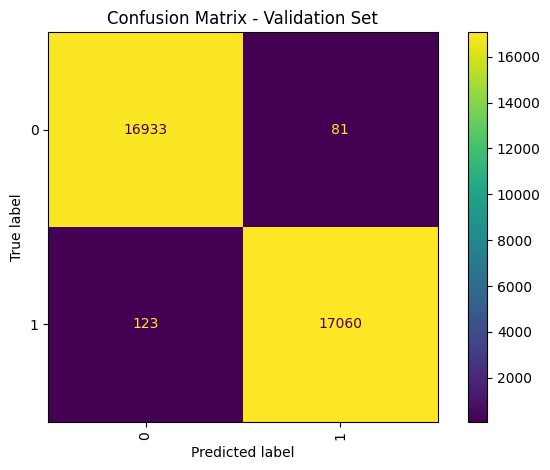

['scaler_encrypted.pkl']

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# --- Load & preprocess encrypted traffic data ---
data_enc = pd.read_csv('encrypted_traffic_features.csv')

# Separate features and labels
X_enc = data_enc.drop(columns=['label'], errors='ignore')
y_enc = data_enc['label']

# Encode labels if they are categorical
if y_enc.dtype == object:
    y_enc = LabelEncoder().fit_transform(y_enc)

# Scale features
enc_scaler = StandardScaler()
X_enc = enc_scaler.fit_transform(X_enc)

# Split into train, validation, test sets
Xe_temp, Xe_test, ye_temp, ye_test = train_test_split(
    X_enc, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

Xe_train, Xe_val, ye_train, ye_val = train_test_split(
    Xe_temp, ye_temp, test_size=0.1, random_state=42, stratify=ye_temp)

# --- Define and train the model ---
model_enc = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(Xe_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_enc)), activation='softmax')  # multi-class
])

model_enc.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = model_enc.fit(
    Xe_train, ye_train,
    epochs=10,
    batch_size=256,
    validation_data=(Xe_val, ye_val),
    verbose=1
)

# --- Evaluate on test set ---
loss, acc_enc = model_enc.evaluate(Xe_test, ye_test, verbose=0)
print(f"\n🔍 Encrypted traffic model test accuracy: {acc_enc:.4f}")
print(f"🧮 Test loss: {loss:.4f}")

# --- Predict and show detailed evaluation on validation set ---
y_val_pred_probs = model_enc.predict(Xe_val)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)

print("\n📊 Classification Report (Validation Set):")
print(classification_report(ye_val, y_val_preds))

cm = confusion_matrix(ye_val, y_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# --- Save model and scaler ---
model_enc.save('model_encrypted.h5')
keras.saving.save_model(model_enc, 'my_model.keras')
joblib.dump(enc_scaler, 'scaler_encrypted.pkl')
